In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import os.path

In [2]:
batch_size = 100
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = torchvision.datasets.MNIST('../data',train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.features = nn.Sequential(
            nn.Linear(196,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Linear(1024,784),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = x.view(batch_size, 196)
        x = self.features(x)
        return x
    
Gnr = Generator()

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(784,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,196),
            nn.ReLU(),
            nn.Linear(196,1),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x = x.view(batch_size, 784)
        x = self.features(x)
        x = x.view(batch_size, -1)
        return x
    
Dsc = Discriminator()

In [5]:
criterion = nn.BCELoss()
Gnr_optimizer = optim.Adam(Gnr.parameters(), lr=0.0001)
Dsc_optimizer = optim.Adam(Dsc.parameters(), lr=0.0001)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Gnr.to(device)
Dsc.to(device)

cuda:0


Discriminator(
  (features): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=196, bias=True)
    (7): ReLU()
    (8): Linear(in_features=196, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [7]:
def noiseInput():
    return torch.randn(batch_size, 196)

test_noise = noiseInput().to(device)
epoch_len = 500

0


/home/hsue/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


/home/hsue/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350


KeyboardInterrupt: 

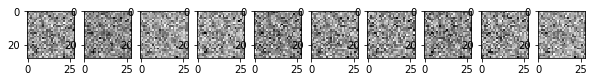

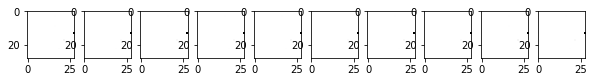

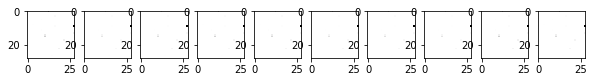

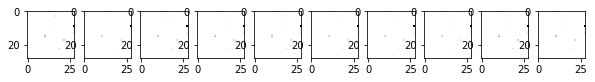

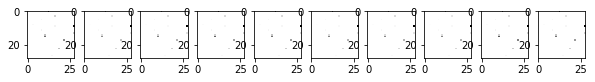

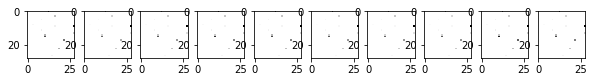

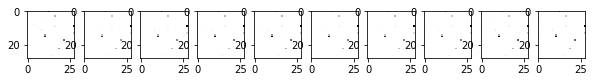

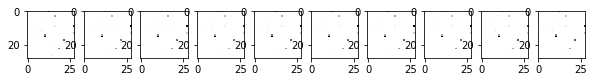

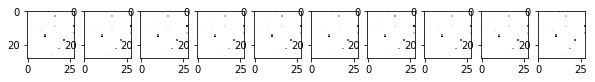

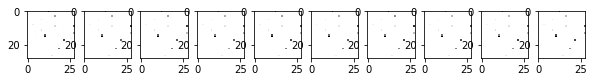

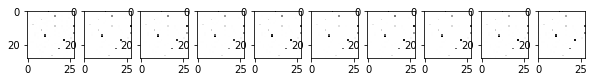

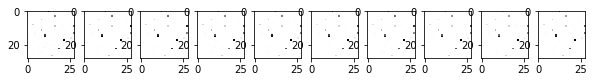

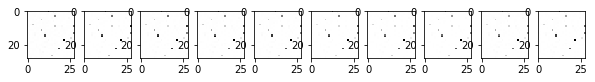

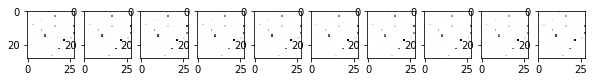

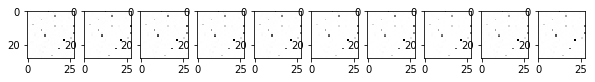

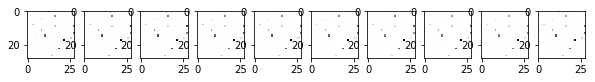

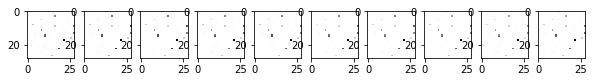

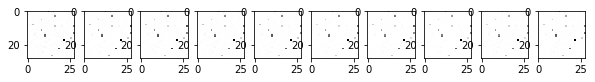

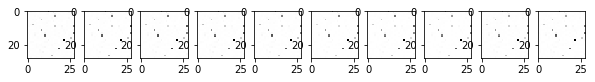

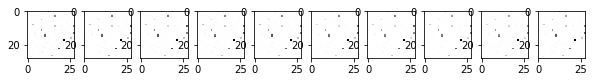

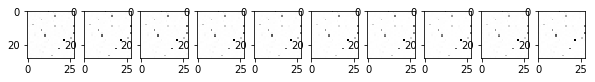

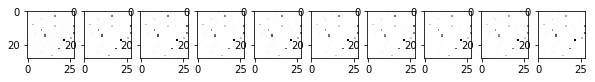

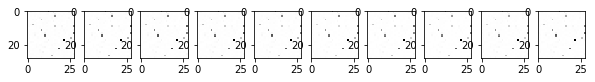

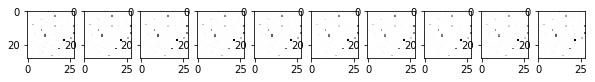

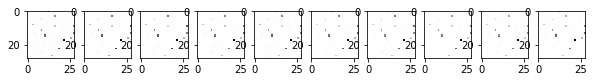

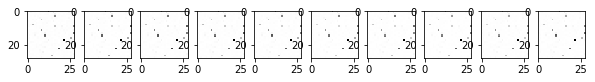

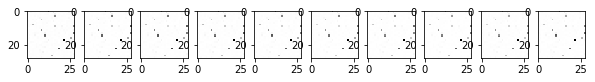

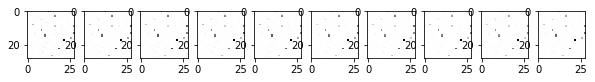

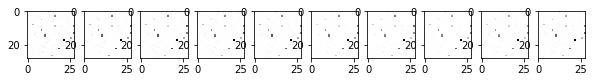

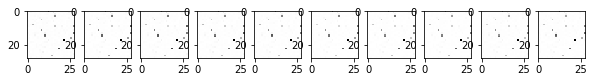

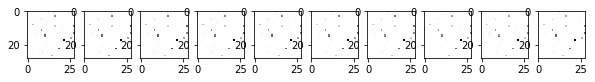

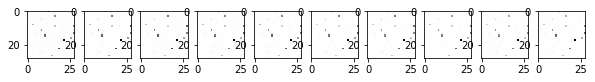

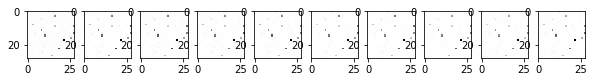

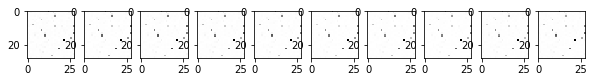

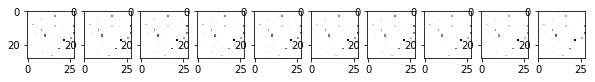

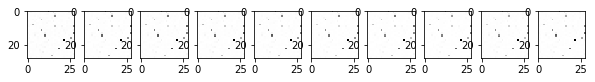

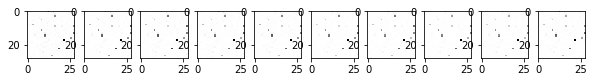

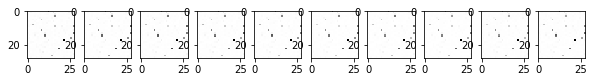

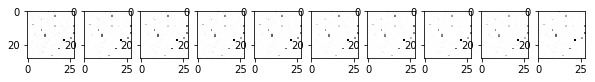

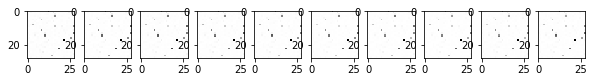

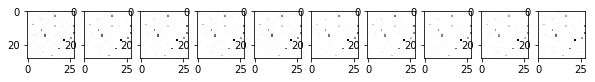

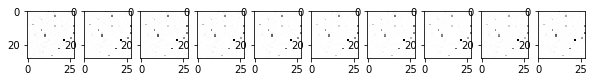

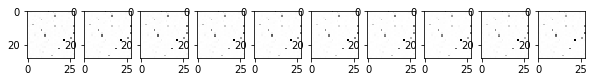

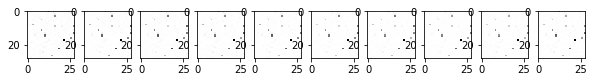

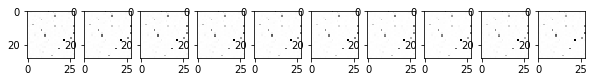

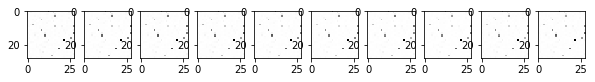

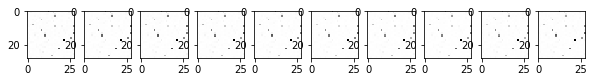

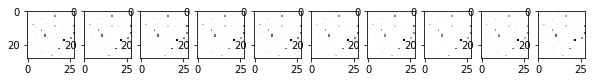

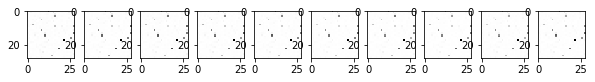

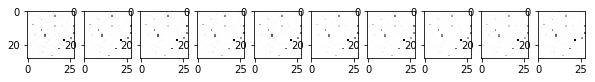

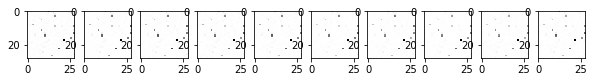

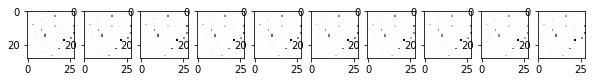

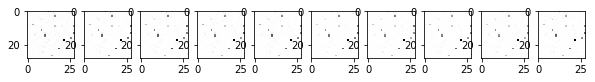

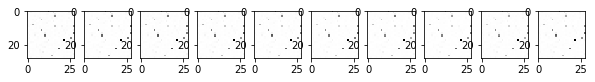

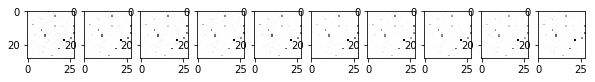

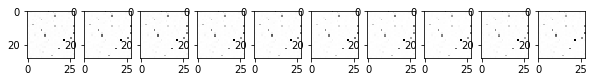

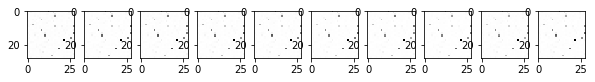

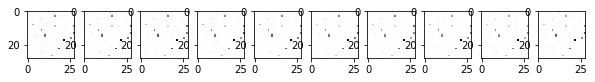

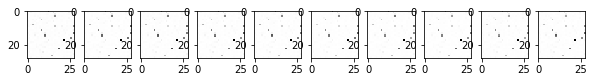

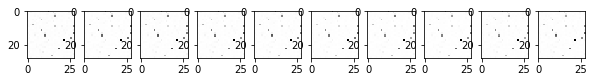

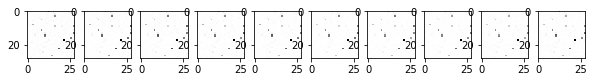

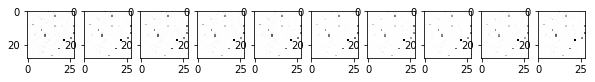

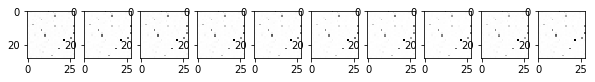

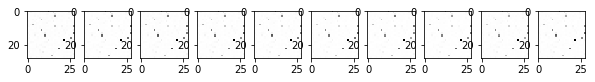

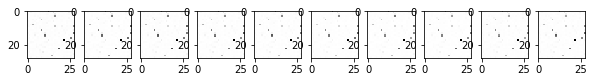

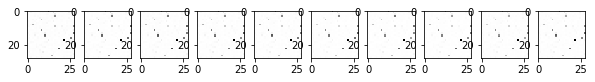

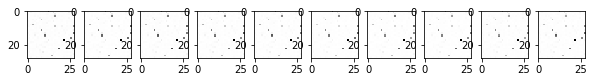

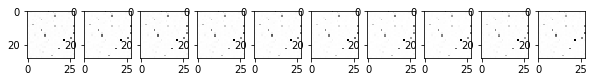

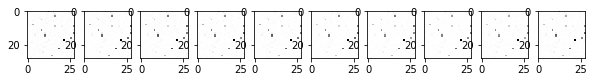

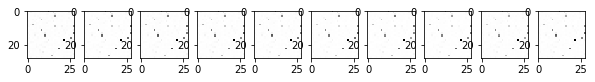

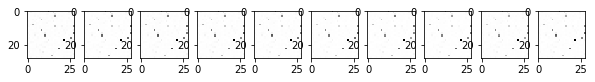

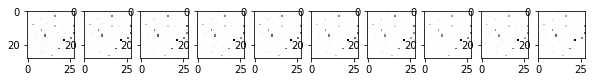

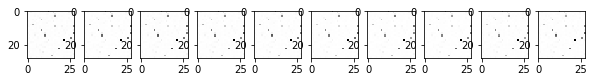

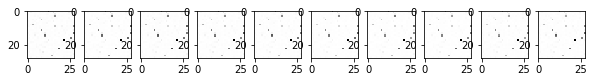

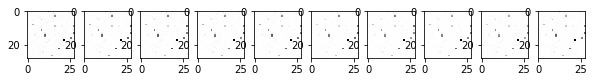

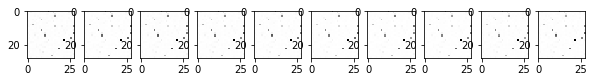

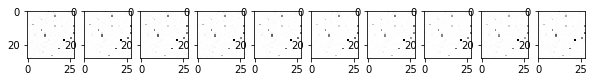

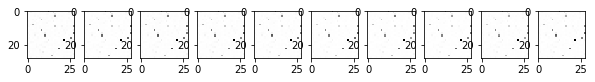

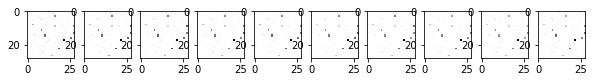

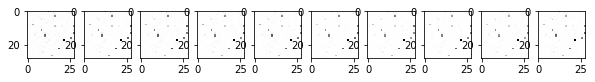

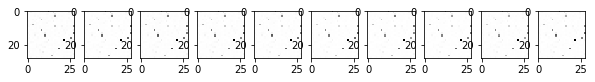

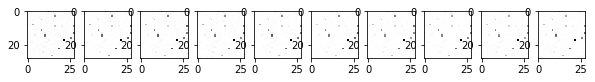

In [8]:
if os.path.isfile('./save/gen.pth'):
    Gnr.load_state_dict(torch.load('./save/gen.pth'))
if os.path.isfile('./save/dsc.pth'):
    Dsc.load_state_dict(torch.load('./save/dsc.pth'))
    
for epoch in range(epoch_len):
    print(epoch)
    for i, data in enumerate(trainloader):
        inputs, _ = data
        inputs = inputs.to(device)
        
        Dsc.zero_grad()
        dsc_real_result = Dsc(inputs)
        dsc_real_error = criterion(dsc_real_result, torch.ones(batch_size).to(device))

        noise = noiseInput().to(device)
        gnr_fake = Gnr(noise)
        dsc_fake_result = Dsc(gnr_fake)
        dsc_fake_error = criterion(dsc_fake_result,torch.zeros(batch_size).to(device))
        
        loss = dsc_real_error + dsc_fake_error
        loss.backward()
        Dsc_optimizer.step()
        
        Gnr.zero_grad()
        noise = noiseInput().to(device)
        gnr_fake = Gnr(noise)
        dsc_gnr_fake_result = Dsc(gnr_fake)
        gnr_error = criterion(dsc_gnr_fake_result, torch.ones(batch_size).to(device))
        gnr_error.backward()
        Gnr_optimizer.step()
        
        if epoch%5 == 0 and i % 1000 == 0:
            plt.figure(epoch, figsize=(10,1))
            gnr_fake = Gnr(test_noise)
            
            fake = gnr_fake.data.cpu()
            fake_img = fake.numpy().reshape(-1,28,28)
            
            for n in range(10):
                plt.subplot(1,10,n+1)
                plt.imshow(fake_img[n], cmap='Greys')
            plt.savefig('./result/result_r'+str(epoch)+'_'+str(int(i/1000))+'.jpg')
            
    torch.save(Gnr.state_dict(),'./save/gen.pth')
    torch.save(Dsc.state_dict(),'./save/dsc.pth')
    